In [1]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator
from model.discriminator import Discrimator

import matplotlib.pyplot as plt

In [2]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Args

In [3]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_2_out_1_ol_0'
frm_in = 2
frm_out = 1
mini_batch = 32
n_epochs = 200

In [4]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Load data

In [5]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [1100, 243])
[train_data, _] = data.random_split(train_data, [1, 1099]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [3, 240])
train_loader = data.DataLoader(train_data, batch_size = 1, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 1
Val size: 3


# Define the network and loss

In [6]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=2, hidden_dim=128, out_filters=256,
                  attention_at=8, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=32, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.5, 0.999))

encoder.apply(weight_init)
generator.apply(weight_init)

summary(encoder, input_size=(3, frm_in, 64, 64))
summary(generator, input_size=(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 16, 1, 32, 32]           1,312
         LeakyReLU-2        [-1, 16, 1, 32, 32]               0
        NormConvND-3        [-1, 16, 1, 32, 32]               0
            Conv3d-4        [-1, 16, 1, 32, 32]              64
         LeakyReLU-5        [-1, 16, 1, 32, 32]               0
        NormConvND-6        [-1, 16, 1, 32, 32]               0
ResidualNormConv3D-7        [-1, 16, 1, 32, 32]               0
            Conv3d-8        [-1, 32, 1, 16, 16]          13,856
         LeakyReLU-9        [-1, 32, 1, 16, 16]               0
       NormConvND-10        [-1, 32, 1, 16, 16]               0
           Conv3d-11        [-1, 32, 1, 16, 16]             544
        LeakyReLU-12        [-1, 32, 1, 16, 16]               0
       NormConvND-13        [-1, 32, 1, 16, 16]               0
ResidualNormConv3D-14        [-1, 32, 1

# Training loop

In [7]:
train_hist_real = []
train_hist_gen = []
val_hist = []
for epoch in range(n_epochs):
        running_loss_gen = 0.0
        running_loss_real = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs and move them to device
            in_frames, out_frames = data
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # zero the parameter gradients
            encoder.zero_grad()
            generator.zero_grad()
            
            # GENERATOR/ENCODER TRAINING
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            
            loss_gen = loss_fun(generated, out_frames)
            
            loss_gen.backward()
            encoder_optim.step()
            generator_optim.step()

            # print statistics
            running_loss_gen += loss_gen.item()# / 10
            #if i % 10 == 9:
            print('[Epoch {0} - Step {1}] R-loss: {2} G-loss: {3}'.format(epoch, i, running_loss_real, running_loss_gen))
            train_hist_real.append(running_loss_real)
            train_hist_gen.append(running_loss_gen)
            running_loss_real = 0
            running_loss_gen = 0

        val_loss = 0.0
        for in_frames, out_frames in val_loader:
            # get the validation inputs and outputs
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # forward
            with torch.no_grad():
                hidden, encoder_attn = encoder(in_frames)
                generated, generator_attn = generator(hidden)
            
            val_loss += loss_fun(generated, out_frames).item() / len(val_loader)
            #val_loss += loss_fun(generated, out_frames).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0 - Step 0] R-loss: 0.0 G-loss: 0.3295704126358032
[Epoch 0] Val-Loss: 0.2424028366804123
[Epoch 1 - Step 0] R-loss: 0.0 G-loss: 0.2879018187522888
[Epoch 1] Val-Loss: 0.1738371948401133
[Epoch 2 - Step 0] R-loss: 0.0 G-loss: 0.2071578949689865
[Epoch 2] Val-Loss: 0.27402036388715106
[Epoch 3 - Step 0] R-loss: 0.0 G-loss: 0.241337850689888
[Epoch 3] Val-Loss: 0.16487839818000793
[Epoch 4 - Step 0] R-loss: 0.0 G-loss: 0.18228679895401
[Epoch 4] Val-Loss: 0.1422965998450915
[Epoch 5 - Step 0] R-loss: 0.0 G-loss: 0.15794700384140015
[Epoch 5] Val-Loss: 0.1336256538828214
[Epoch 6 - Step 0] R-loss: 0.0 G-loss: 0.14858224987983704
[Epoch 6] Val-Loss: 0.12568369507789612
[Epoch 7 - Step 0] R-loss: 0.0 G-loss: 0.1372797191143036
[Epoch 7] Val-Loss: 0.11858111868302026
[Epoch 8 - Step 0] R-loss: 0.0 G-loss: 0.12282321602106094
[Epoch 8] Val-Loss: 0.1210969015955925
[Epoch 9 - Step 0] R-loss: 0.0 G-loss: 0.11374285817146301
[Epoch 9] Val-Loss: 0.11883471657832463
[Epoch 10 - Step 0] R-lo

[Epoch 81] Val-Loss: 0.10279632980624834
[Epoch 82 - Step 0] R-loss: 0.0 G-loss: 0.04537360370159149
[Epoch 82] Val-Loss: 0.07760715236266454
[Epoch 83 - Step 0] R-loss: 0.0 G-loss: 0.050791770219802856
[Epoch 83] Val-Loss: 0.07912402724226317
[Epoch 84 - Step 0] R-loss: 0.0 G-loss: 0.043269723653793335
[Epoch 84] Val-Loss: 0.1080414243042469
[Epoch 85 - Step 0] R-loss: 0.0 G-loss: 0.047673288732767105
[Epoch 85] Val-Loss: 0.07875115796923637
[Epoch 86 - Step 0] R-loss: 0.0 G-loss: 0.04795761778950691
[Epoch 86] Val-Loss: 0.08180816968282063
[Epoch 87 - Step 0] R-loss: 0.0 G-loss: 0.04395834729075432
[Epoch 87] Val-Loss: 0.10332891220847766
[Epoch 88 - Step 0] R-loss: 0.0 G-loss: 0.04350427910685539
[Epoch 88] Val-Loss: 0.074679351101319
[Epoch 89 - Step 0] R-loss: 0.0 G-loss: 0.045771658420562744
[Epoch 89] Val-Loss: 0.08471388121445975
[Epoch 90 - Step 0] R-loss: 0.0 G-loss: 0.04169873893260956
[Epoch 90] Val-Loss: 0.09356918310125668
[Epoch 91 - Step 0] R-loss: 0.0 G-loss: 0.0389959

[Epoch 161] Val-Loss: 0.08318731685479483
[Epoch 162 - Step 0] R-loss: 0.0 G-loss: 0.03072485141456127
[Epoch 162] Val-Loss: 0.10195941105484962
[Epoch 163 - Step 0] R-loss: 0.0 G-loss: 0.03185437619686127
[Epoch 163] Val-Loss: 0.07779381796717644
[Epoch 164 - Step 0] R-loss: 0.0 G-loss: 0.034565266221761703
[Epoch 164] Val-Loss: 0.09761330857872963
[Epoch 165 - Step 0] R-loss: 0.0 G-loss: 0.03126261383295059
[Epoch 165] Val-Loss: 0.08836215361952782
[Epoch 166 - Step 0] R-loss: 0.0 G-loss: 0.02985118329524994
[Epoch 166] Val-Loss: 0.0863222343226274
[Epoch 167 - Step 0] R-loss: 0.0 G-loss: 0.029900074005126953
[Epoch 167] Val-Loss: 0.09510373820861182
[Epoch 168 - Step 0] R-loss: 0.0 G-loss: 0.029714852571487427
[Epoch 168] Val-Loss: 0.08540453637639682
[Epoch 169 - Step 0] R-loss: 0.0 G-loss: 0.029542071744799614
[Epoch 169] Val-Loss: 0.09548147643605867
[Epoch 170 - Step 0] R-loss: 0.0 G-loss: 0.029486095532774925
[Epoch 170] Val-Loss: 0.084194615483284
[Epoch 171 - Step 0] R-loss: 

# Results visualization

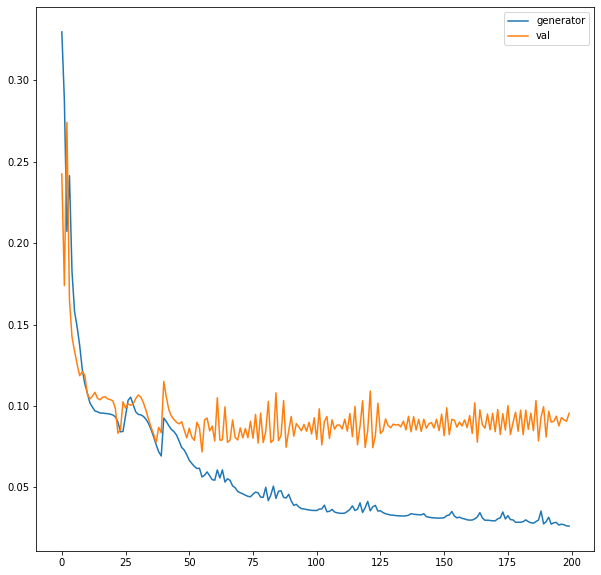

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(train_hist_gen)
plt.plot(val_hist)
plt.legend(['generator', 'val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 2, 64, 64])
torch.Size([1, 3, 1, 64, 64])


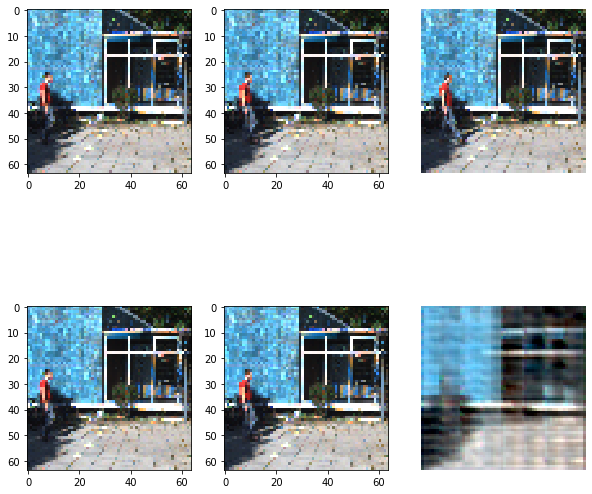

In [9]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
print(insamp.shape)
print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)

with torch.no_grad():
    hidval, encval_attn = encoder(insamp)
    genval, genval_attn = generator(hidval)

insamp = insamp.cpu().squeeze().permute(1,2,3,0).numpy()
genval = genval.cpu().squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(10, 10))
# img
plt.subplot(2, frm_in+frm_out, 1)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 2)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 3)
plt.imshow(outsamp)
plt.axis('off')

# target
plt.subplot(2, frm_in+frm_out, 4)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 5)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 6)
plt.imshow(genval)
plt.axis('off')
plt.show()

In [10]:
encval_attn = encval_attn.cpu().squeeze().detach().numpy()
genval_attn = genval_attn.cpu().squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(64, 8, 8)
(32, 32, 32)


In [11]:
print(encval_attn[0,:,:])

[[-0.01361651 -0.0096021  -0.00512923 -0.01214119 -0.00251732  0.00775072
  -0.00068562  0.00416887]
 [-0.01361526 -0.00960195 -0.00512979 -0.01214147 -0.00251645  0.00775122
  -0.00068504  0.00416813]
 [-0.01361996 -0.00960098 -0.0051259  -0.01214373 -0.00252233  0.00774767
  -0.00068917  0.00416925]
 [-0.01361874 -0.00960135 -0.00512682 -0.01214274 -0.00252042  0.00774835
  -0.0006879   0.00416904]
 [-0.01362243 -0.00959958 -0.00512358 -0.01214453 -0.00252482  0.00774533
  -0.00069122  0.00417012]
 [-0.01362063 -0.0096006  -0.00512576 -0.01214286 -0.00252218  0.00774735
  -0.00068971  0.00416992]
 [-0.01361768 -0.00960153 -0.00512789 -0.01214184 -0.00251922  0.00774953
  -0.00068751  0.00416876]
 [-0.01362087 -0.00959994 -0.00512492 -0.01214397 -0.0025233   0.0077468
  -0.00069033  0.00416963]]


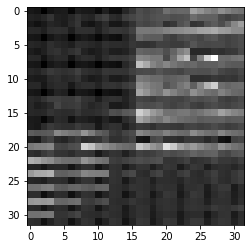

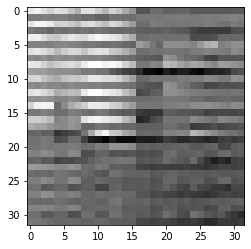

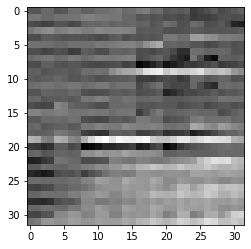

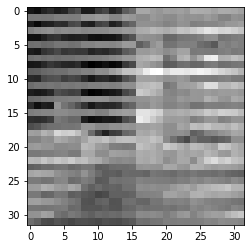

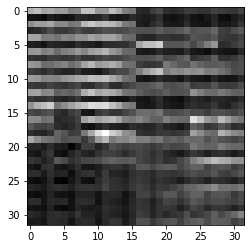

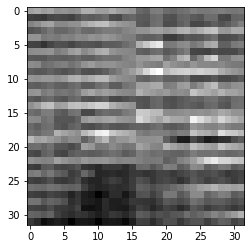

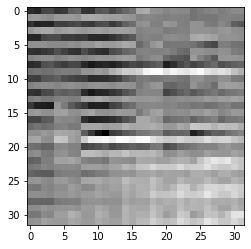

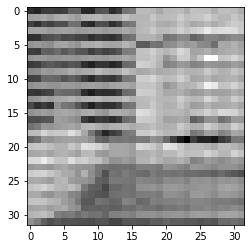

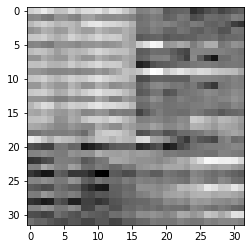

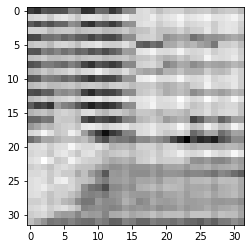

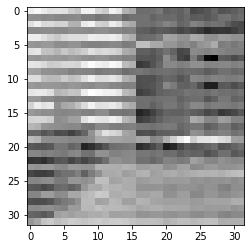

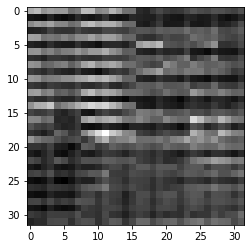

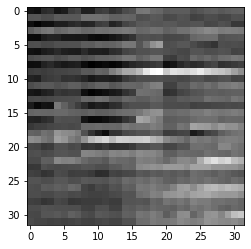

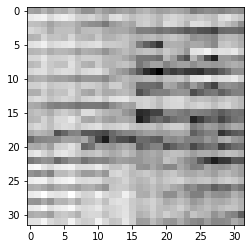

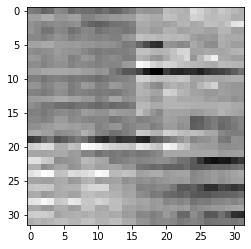

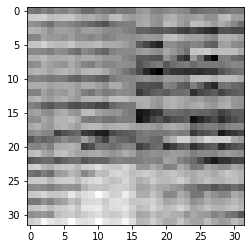

In [14]:
for idx in range(16):#genval_attn.shape[0]):
    plt.imshow(genval_attn[idx,:,:], cmap = 'gray')
    plt.show()